# Importing Necessary libraries

In [8]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2 
import glob
import random
import os 
from sklearn.metrics import classification_report
import tensorflow as tf
import keras.utils as image
import shutil
from shutil import copyfile
from sklearn.model_selection import train_test_split
from tqdm import tqdm


# Loading Dataset

In [9]:
shutil.rmtree('/kaggle/working/breast-histopathology-images')

In [10]:
try:
    os.mkdir('/kaggle/working/breast-histopathology-images')
    os.mkdir('/kaggle/working/breast-histopathology-images/training')
    os.mkdir('/kaggle/working/breast-histopathology-images/validation')
    os.mkdir('/kaggle/working/breast-histopathology-images/test')
    os.mkdir('/kaggle/working/breast-histopathology-images/training/negative')
    os.mkdir('/kaggle/working/breast-histopathology-images/training/positive')
    os.mkdir('/kaggle/working/breast-histopathology-images/validation/negative')
    os.mkdir('/kaggle/working/breast-histopathology-images/validation/positive')
    os.mkdir('/kaggle/working/breast-histopathology-images/test/negative')
    os.mkdir('/kaggle/working/breast-histopathology-images/test/positive')
except OSError:
    print('Error failed to make directory')

In [11]:
file_img_neg = glob.glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/*/0/*.png')
file_img_pos = glob.glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/*/1/*.png')

In [12]:
print(len(file_img_neg), len(file_img_pos))

198738 78786


In [13]:
train_img_neg, val_img_neg = train_test_split(file_img_neg[:12389], test_size=0.2, random_state=42)
train_img_pos, val_img_pos = train_test_split(file_img_pos[:12389], test_size=0.2, random_state=42)

In [14]:
for img_path in tqdm(train_img_neg):
    filename = os.path.basename(img_path)
    copyfile(img_path, f'/kaggle/working/breast-histopathology-images/training/negative/{filename}')

for img_path in tqdm(train_img_pos):
    filename = os.path.basename(img_path)
    copyfile(img_path, f'/kaggle/working/breast-histopathology-images/training/positive/{filename}')

for img_path in tqdm(val_img_neg):
    filename = os.path.basename(img_path)
    copyfile(img_path, f'/kaggle/working/breast-histopathology-images/validation/negative/{filename}')

for img_path in tqdm(val_img_pos):
    filename = os.path.basename(img_path)
    copyfile(img_path, f'/kaggle/working/breast-histopathology-images/validation/positive/{filename}')


100%|██████████| 2478/2478 [00:17<00:00, 141.51it/s]


# Data Preprocessing

In [63]:
from skimage import io
from skimage.color import rgb2hed, hed2rgb

def stain_normalization(image):
    """
    Apply stain normalization to an image using the Reinhard method.
    """
    # Convert the image to HED color space
    ihc_hed = rgb2hed(image)
    
    # Define target mean and standard deviations for HED channels
    target_hed_mean = np.array([0.18, 0.18, 0.18])
    target_hed_std = np.array([0.1, 0.1, 0.1])
    
    # Calculate the means and standard deviations of the HED channels
    hed_mean = np.mean(ihc_hed, axis=(0, 1))
    hed_std = np.std(ihc_hed, axis=(0, 1))
    
    # Perform stain normalization
    ihc_hed_normalized = (ihc_hed - hed_mean) / hed_std * target_hed_std + target_hed_mean
    
    # Convert the normalized image back to RGB color space
    normalized_image = hed2rgb(ihc_hed_normalized)
    
    return normalized_image

# Modeling

In [16]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [17]:
train_datagen = ImageDataGenerator(
#     preprocessing_function=stain_normalization,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(
#     preprocessing_function=stain_normalization,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [18]:
train_data_dir = '/kaggle/working/breast-histopathology-images/training'
valid_data_dir = '/kaggle/working/breast-histopathology-images/validation'
train_set = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(50, 50),
    batch_size=32,
    color_mode="rgb",
    shuffle=True,
    class_mode='binary'
)

val_set = val_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(50, 50),
    batch_size=32,
    color_mode="rgb",
    shuffle=True,
    class_mode='binary')

Found 19822 images belonging to 2 classes.
Found 4956 images belonging to 2 classes.


In [29]:
test_neg = file_img_neg[12389:13389]
test_pos = file_img_pos[12389:13389]

for img_path in tqdm(test_neg):
    filename = os.path.basename(img_path)
    copyfile(img_path, f'/kaggle/working/breast-histopathology-images/test/negative/{filename}')

for img_path in tqdm(test_pos):
    filename = os.path.basename(img_path)
    copyfile(img_path, f'/kaggle/working/breast-histopathology-images/test/positive/{filename}')

100%|██████████| 1000/1000 [00:07<00:00, 130.96it/s]


In [30]:
test_datagen = ImageDataGenerator(
)
test_dir  = '/kaggle/working/breast-histopathology-images/test'
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(50,50),
    batch_size=1,
    shuffle=False,
    class_mode='binary',
    color_mode='rgb'
)

Found 2000 images belonging to 2 classes.


# train model efficientnet b0

In [19]:
!pip install -U efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.6 MB/s eta 0:00:00


In [20]:
from keras.layers import Dense
from keras.optimizers import Adam
from keras.applications import EfficientNetB0  # Import EfficientNetB0

efficient_net = EfficientNetB3(
    weights='imagenet',
    input_shape=(50, 50, 3),  # Adjust input shape to (50, 50, 3)
    include_top=False,
    pooling='max'
)

model_b0 = Sequential()
model_b0.add(efficient_net)
model.add(BatchNormalization())
model_b0.add(Dense(120, activation='relu'))
model.add(BatchNormalization())
model_b0.add(Dense(120, activation='relu'))
model_b0.add(Dense(2, activation='softmax'))
model_b0.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense (Dense)               (None, 120)               153720    
                                                                 
 dense_1 (Dense)             (None, 120)               14520     
                                                                 
 dense_2 (Dense)             (None, 1)                 121       
                                                                 
Total params: 4,217,932
Trainable params: 4,175,909
Non-trainable params: 42,023
_________________________________________________________________


In [22]:
model_b0.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
history_b0 = model_b0.fit_generator(
    train_set,
    epochs = 20,
    validation_data = val_set,
    verbose=1
)

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """
2024-04-27 15:15:07.541494: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


620/620 [==============================] - 51s 57ms/step - loss: 0.4419 - accuracy: 0.7975 - val_loss: 0.3722 - val_accuracy: 0.8467
Epoch 2/20
620/620 [==============================] - 33s 53ms/step - loss: 0.3525 - accuracy: 0.8513 - val_loss: 0.3314 - val_accuracy: 0.8606
Epoch 3/20
620/620 [==============================] - 33s 53ms/step - loss: 0.3183 - accuracy: 0.8664 - val_loss: 0.3085 - val_accuracy: 0.8695
Epoch 4/20
620/620 [==============================] - 33s 53ms/step - loss: 0.2958 - accuracy: 0.8779 - val_loss: 0.2927 - val_accuracy: 0.8805
Epoch 5/20
620/620 [==============================] - 32s 52ms/step - loss: 0.2717 - accuracy: 0.8857 - val_loss: 0.2863 - val_accuracy: 0.8832
Epoch 6/20
620/620 [==============================] - 33s 53ms/step - loss: 0.2575 - accuracy: 0.8929 - val_loss: 0.2741 - val_accuracy: 0.8882
Epoch 7/20
620/620 [==============================] - 33s 53ms/step - loss: 0.2409 - accuracy: 0.9019 - val_loss: 0.2636 - val_accuracy: 0.8933
Epo

# evaluation

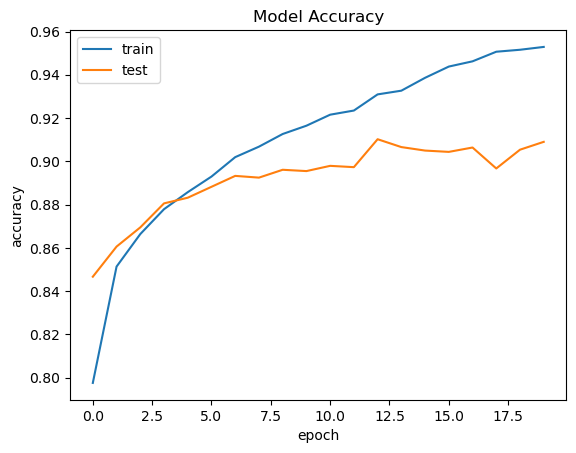

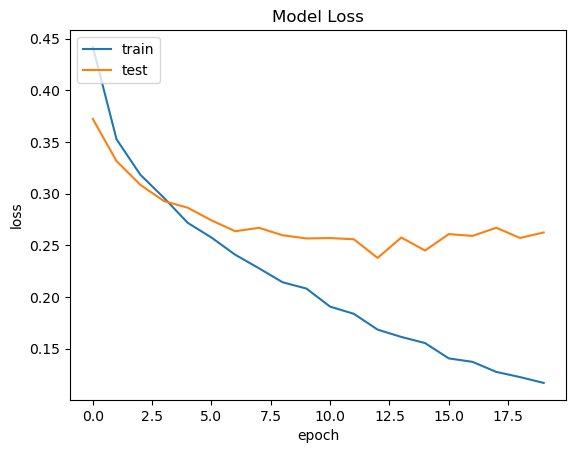

In [25]:
plt.plot(history_b0.history['accuracy'])
plt.plot(history_b0.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history_b0.history['loss'])
plt.plot(history_b0.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

accuracy == 0.786


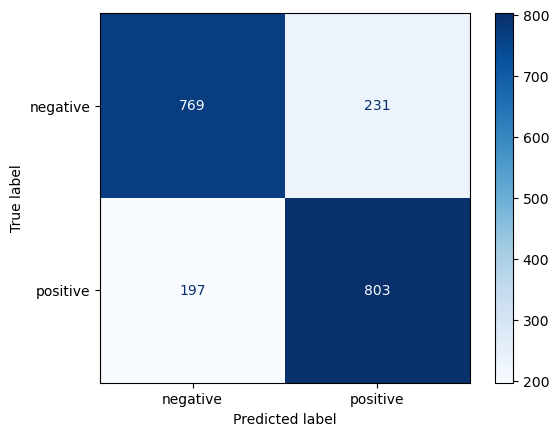

In [46]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predicted_classes = np.argmax(preds_b0, axis=1)  # assuming softmax output
true_labels = test_generator.labels

cm = confusion_matrix(true_labels, predicted_classes)

labels = test_generator.class_indices.keys()  # Get class labels
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
display.plot(cmap='Blues')  # plot the confusion matrix


## VGG16

In [68]:
early_stop=EarlyStopping(monitor='val_loss',patience=5)
input_shape = X_train.shape[1:]
vgg16_model = Sequential()

# Block 1
vgg16_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
vgg16_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
vgg16_model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 2
vgg16_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
vgg16_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
vgg16_model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 3
vgg16_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
vgg16_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
vgg16_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
vgg16_model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 4
vgg16_model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
vgg16_model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
vgg16_model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
vgg16_model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 5
vgg16_model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
vgg16_model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
vgg16_model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
vgg16_model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Fully connected layers
vgg16_model.add(Flatten())
vgg16_model.add(Dense(4096, activation='relu'))
vgg16_model.add(Dense(4096, activation='relu'))
vgg16_model.add(Dense(1, activation='sigmoid'))  # Binary classification output

In [69]:
vgg16_model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [70]:
vgg16_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 50, 50, 64)        1792      
                                                                 
 conv2d_14 (Conv2D)          (None, 50, 50, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 25, 25, 128)       73856     
                                                                 
 conv2d_16 (Conv2D)          (None, 25, 25, 128)       147584    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 12, 128)      0         
 2D)                                                  

In [71]:
vgg16_history = vgg16_model.fit(train_set,
                     validation_data=val_set,
                    epochs=20, verbose=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


Epoch 1/20
10/10 [==============================] - 16s 186ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/20
10/10 [==============================] - 1s 107ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/20
10/10 [==============================] - 1s 96ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/20
10/10 [==============================] - 1s 95ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/20
10/10 [==============================] - 1s 97ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/20
10/10 [==============================] - 1s 98ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/20
10/10 [==============================] - 1s 96ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 8/20

In [ ]:
plt.plot(vgg16_history.history['accuracy'])
plt.plot(vgg16_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(vgg16_history.history['loss'])
plt.plot(vgg16_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()